In [374]:
# Clear notebook variables to start. 
%reset -f

In [375]:
# Import dependencies and set matplotlib to display inline 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from random import randint
from math import sqrt
from IPython import display
%matplotlib inline 

In [376]:
# Load data into a pandas dataframe
df = pd.read_csv('../Data/mall_customers.csv')

In [377]:
# A True value shuffles data rows
shuffle_on = False
if shuffle_on:
    df = df.sample(frac=1)

In [378]:
# Print data dimensionality. Then display first few rows
print('Numpy shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data featrues:', df.shape[1])
print('Number of dimensions:', df.ndim)
df.head()

Numpy shape: (200, 5)
Number of data examples: 200
Number of data featrues: 5
Number of dimensions: 2


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [379]:
# Display summary statistics of the data
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [380]:
# Define dataset from existing dataframe
x = df['Age'].to_numpy()
y = df['Annual Income (k$)'].to_numpy()

print(type(x), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [381]:
# Set number of clusters 
k = 4

In [382]:
# Initialize centroids at random locations within reasonable range.
# This includes a margin so that centroids are not placed at edge of the range

def initialize_centroids(x_data, y_data, k):
    """Randomly instantiate centroids and return their coordinates in separate lists for x and y components.
    
    Generates k number centroids at random locations within range of the data, which is 
    calculated and then reduced by 20%. This reduction is specified by the local variable
    'margin' and prevents cluster centroids from instantiating at the edge of the set, which 
    is less than optimal for the k means algorithm. 

    Args:
        x_data (numpy.ndarray): data for independent variable.
        y_data (numpy.ndarray): data for dependent variable.
        k (int): desired number of centroids/clusters.

    Returns:
        initial_centroids_x_coords: a list of length k, where each element is the x-coordinate of a centroid.
        initial_centroids_y_coords: a list of length k, where each element is the y-coordinate of a centroid.

    """
    x_max = np.amax(x_data) 
    x_min = np.amin(x_data)
    y_max = np.amax(y_data)
    y_min = np.amin(y_data)
    margin = 0.20 # Precludes centroids at edge of data range
    
    initial_centroids_x_coords = [] # List of x coordinates of all centroids
    initial_centroids_y_coords = [] # List of y coordinates of all centroids

    for i in range(k):
        initial_centroids_x_coords.append(randint(x_min, x_max)*(1-margin))
        initial_centroids_y_coords.append(randint(y_min, y_max)*(1-margin))

    return initial_centroids_x_coords, initial_centroids_y_coords

# Set number of clusters 
k = 4
k_x, k_y = initialize_centroids(x, y, k)
print('Centroid coordinates:')
for j in range(k):
    print(k_x[j],', ',k_y[j], sep='')
    
print(type(k_x), type(k_y))
print(len(k_x))
print(len(x))
print(len(y))

Centroid coordinates:
41.6, 22.400000000000002
39.2, 98.4
39.2, 100.0
16.8, 88.80000000000001
<class 'list'> <class 'list'>
4
200
200


In [383]:
# Make an empty numpy array of size k x len(x) to store distances to centroids
# Build in extra row for the minimum distance value
d = np.zeros([k + 1, len(x)])
d.shape

(5, 200)

In [384]:
def find_distance(x1, y1, x2, y2):
    """Find Euclidean distance between a point (x1, y1) and another point (x2, y2).
    
    In the context of k means clustering, for a given set containing data points of the form (x, y),
    find the distance between every point in that set and every centroid's point (of the form k_x, k_y).

    Args:
        x1 (int or float): x coordinate of first point.
        y1 (int or float): y coordinate of first point.
        x2 (int or float): x coordinate of second point.
        y2 (int or float): y coordinate of second point.

    Returns:
        distance: as a float. 

    """
    distance = sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return distance

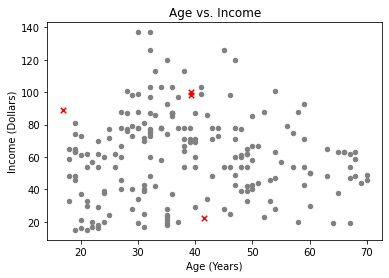

In [385]:
# Visualize data (grey) and starting centroid locations (red)
figure(facecolor='w')
plt.scatter(x, y, s=20, color='grey')
plt.scatter(k_x, k_y, s = 30, color='red', marker='x')
plt.title('Age vs. Income')
plt.xlabel('Age (Years)')
plt.ylabel('Income (Dollars)')
plt.show()

In [386]:
print(len(x))

200


In [387]:
# Iteratively find the distance between every point and every center. 
# Construct array d containing distances from every point to every centroid
# Rows (except last) = distances from data points to each centroid k_n
# Last Row of d = min(column), ie distances of data points to closes centroid
# Col of d = distance from datapoint m to each centroid k_n, min is last row

def make_clusters(x, y, k, d):
    clusters = {}
    for j in range(len(x)): #200
        min_distance = 9999999999 # Arbitrarily large number 
        x_i, y_i = x[j], y[j] # Select (x, y) coords of one data point at a time
        for i in range(0, k): # k = number of clusters
            k_xi, k_yi = k_x[i], k_y[i] # Coordinates of the centroids 
            distance = find_distance(x_i, y_i, k_xi, k_yi)
            if distance < min_distance:
                min_distance = distance 
                centroid_coords = k_xi, k_yi
            d[i,j] = distance

        try: 
            clusters[centroid_coords].append(tuple([x_i, y_i]))
        except KeyError:
            clusters[centroid_coords] = [tuple([x_i, y_i])]

        # Uncomment below to see a printout of data points and their nearest centroids. 
        # print("Datapoint:",j,", x:",x_i,", y:",y_i,", Minimum distance:",min_distance, ", Nearest_centroid:", centroid_coords)

        col = d[:k,j]
        alt_min_distance = np.amin(col)
        d[k,j] = alt_min_distance
        
    return clusters

clusters = make_clusters(x, y, k, d)
print('TYPE of clusters:',type(clusters))
print(clusters.keys())

TYPE of clusters: <class 'dict'>
dict_keys([(41.6, 22.400000000000002), (16.8, 88.80000000000001), (39.2, 98.4), (39.2, 100.0)])


In [388]:
# print("Number of entries in clusters dict:", len(clusters), "; Keys:",clusters.keys())
# print("Centroid coords:")
# for i in range(k):
#     print(k_x[i], k_y[i])

In [389]:
def mean(lst):
    pass
    # return sum(lst)/len(lst)

In [390]:
def make_centers(k, clusters):
    centers = []
    for i in range(k):
        m_x = 0
        m_y = 0
        items = 0
        for coord in clusters[k_x[i], k_y[i]]:
            items +=1 
            m_x += coord[0]
            m_y += coord[1]
        m_x = m_x/items
        m_y = m_y/items
        centers.append((m_x,m_y))
    return centers

centers = make_centers(k, clusters)
#print(centers)

In [391]:
def get_individual_clusters(clusters):
    """Receives a dictionary of centroid coordinates and associated clusters' member data points.  

    Args:
        clusters (dict): a dictionary containing centroid coordinates (as keys) and datapoints which have been
        assigned to that centroid's cluster (as values)
            key (tuple of the form x, y): coordinates of a centroid
            value (list of tuples): each is a list of variable length containing member data coordinates like (x, y)

    Returns:
        ??? 

    """

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (57, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (38, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (67, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (46, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (48, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (55, 57) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (50, 58) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (68, 59) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (48, 60) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (20, 61) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (23, 62) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (26, 62) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (21, 62) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (19, 63) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (38, 64) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (19, 64) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (18, 65) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (19, 65) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (2

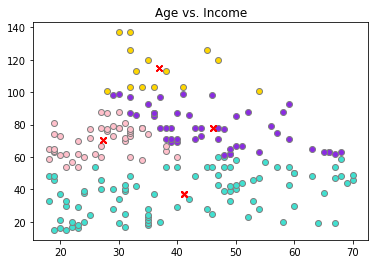

In [392]:
def plot_clusters(clusters):
    """Plots data, with different colors signifying members of different clusters, as well as centroids. 

    Args:
        clusters (dict): a dictionary containing centroid coordinates (as keys) and datapoints which have been
        assigned to that centroid's cluster (as values)
            key (tuple of the form x, y): coordinates of a centroid
            value (list of tuples): each is a list of variable length containing member data coordinates like (x, y)

    Returns:
        None 

    """
    colors = ['turquoise', 'blueviolet', 'gold', 'pink'] # TODO: update with more colors in case of k > 4.
    figure(facecolor='w')

    i = 0
    for i in range(k): # TODO: this function should only plot. Make separate function to pull coords
        for coord in clusters[k_x[i], k_y[i]]: # Goal: to plot each guardian centroid's points in a separate color
            print('Member data point coords:',coord, 'type:', type(coord)) # Input should be data points for ONE centroid
            print('Guardian centroid coords:', k_x[i], ',', k_y[i]) # This can be parsed out before plot fn is called
            plt.scatter(coord[0], coord[1], color=colors[i], edgecolor='grey')
            plt.scatter(centers[i][0], centers[i][1], s= 30, color = 'red', marker='x')

    plt.title('Age vs. Income')
    plt.show()
    
plot_clusters(clusters)

10
Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data poin

Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (45, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (40, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (49, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (57, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (38, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (67, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (46, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (48, 54) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (55, 57) type: <class 'tuple'>
Guardian centroid c

Member data point coords: (19, 64) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (18, 65) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (19, 65) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (27, 67) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (38, 67) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (23, 70) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (31, 70) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (25, 72) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (31, 72) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (2

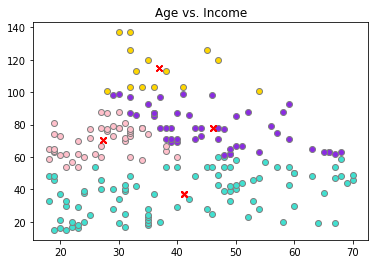

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (44, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (38, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (47, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (56, 79) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (50, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (42, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 't

Member data point coords: (27, 88) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001


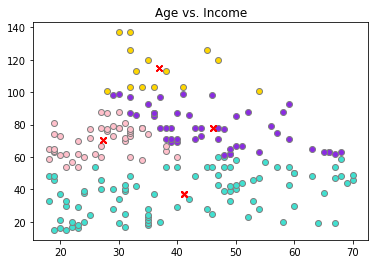

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (37, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (56, 79) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (50, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (42, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 't

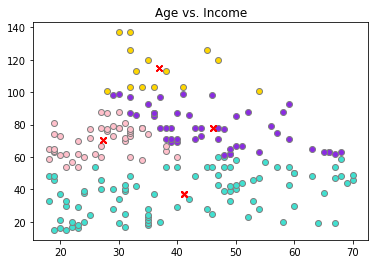

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (52, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (58, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (59, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (35, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 97) type: <class 't

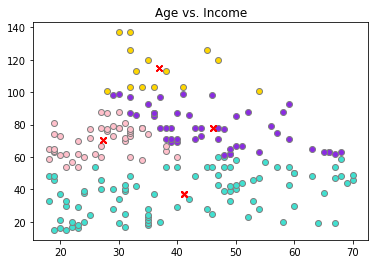

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (52, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (58, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (59, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (35, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 97) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 97) type: <class 't

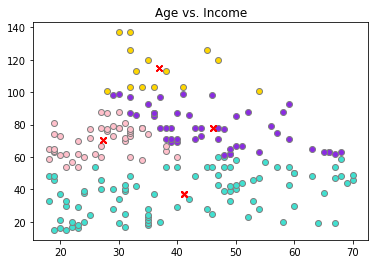

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (39, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (44, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (38, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (47, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (56, 79) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (50, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (42, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 't

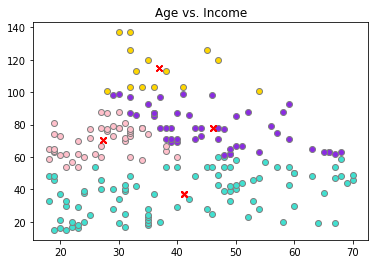

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (37, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (56, 79) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (50, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (42, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 't

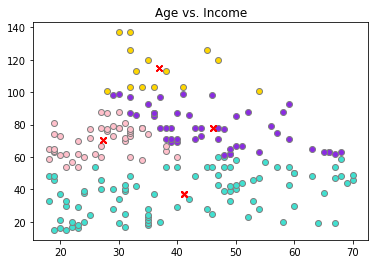

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (47, 71) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (39, 71) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (44, 73) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (57, 75) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (48, 77) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (43, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (39, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (44, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (38, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (47, 78) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 78) type: <class 't

Member data point coords: (28, 87) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (30, 88) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001
Member data point coords: (27, 88) type: <class 'tuple'>
Guardian centroid coords: 16.8 , 88.80000000000001


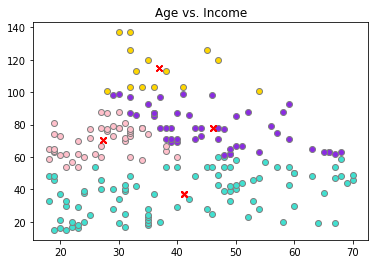

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (56, 79) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (50, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 85) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (42, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (33, 86) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (52, 88) type: <class 't

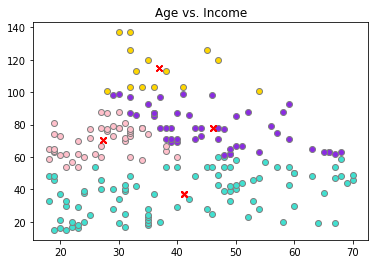

Member data point coords: (19, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (21, 15) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (20, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 16) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (31, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (22, 17) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (35, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (23, 18) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point coords: (64, 19) type: <class 'tuple'>
Guardian centroid coords: 41.6 , 22.400000000000002
Member data point c

Member data point coords: (40, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (36, 87) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (52, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (58, 88) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (59, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (35, 93) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (37, 97) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (32, 97) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (46, 98) type: <class 'tuple'>
Guardian centroid coords: 39.2 , 98.4
Member data point coords: (29, 98) type: <class 't

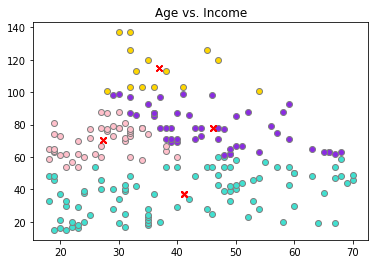

In [393]:
MAX_ITERATIONS = 10

print(MAX_ITERATIONS)
for i in range(MAX_ITERATIONS):
    clusters = make_clusters(x, y, k, d)
    # Add a function here to pull data points for one centroid at a time - to feed into plot_clusters
    plot_clusters(clusters)
    centers = make_centers(k, clusters)

In [394]:
print(k_x)
print(clusters)

[41.6, 39.2, 39.2, 16.8]
{(41.6, 22.400000000000002): [(19, 15), (21, 15), (20, 16), (23, 16), (31, 17), (22, 17), (35, 18), (23, 18), (64, 19), (30, 19), (67, 19), (35, 19), (58, 20), (24, 20), (37, 20), (22, 20), (35, 21), (20, 21), (52, 23), (35, 23), (35, 24), (25, 24), (46, 25), (31, 25), (54, 28), (29, 28), (45, 28), (35, 28), (40, 29), (23, 29), (60, 30), (21, 30), (53, 33), (18, 33), (49, 33), (21, 33), (42, 34), (30, 34), (36, 37), (20, 37), (65, 38), (24, 38), (48, 39), (31, 39), (49, 39), (24, 39), (50, 40), (27, 40), (29, 40), (31, 40), (49, 42), (33, 42), (31, 43), (59, 43), (50, 43), (47, 43), (51, 44), (69, 44), (27, 46), (53, 46), (70, 46), (19, 46), (67, 47), (54, 47), (63, 48), (18, 48), (43, 48), (68, 48), (19, 48), (32, 48), (70, 49), (47, 49), (60, 50), (60, 50), (59, 54), (26, 54), (45, 54), (40, 54), (49, 54), (57, 54), (38, 54), (67, 54), (46, 54), (48, 54), (55, 57), (50, 58), (68, 59), (48, 60), (47, 60)], (16.8, 88.80000000000001): [(23, 54), (21, 54), (22, 5

In [395]:
#TEST AREA
# colors = ['turquoise', 'blueviolet', 'gold', 'pink']
# i = 0
# for i in range(k):
#     for coord in clusters[k_x[i], k_y[i]]:
#         plt.scatter(coord[0], coord[1], color=colors[i], edgecolor='grey')
#         plt.scatter(centers[i][0], centers[i][1], s= 30, color = 'red', marker='x')

# print('k_x:',k_x[i])
# print('k_y:',k_y[i])
# print(clusters[k_x[i], k_y[i]]) 